# Problem 1: Building a real-bogus classifier

In this assignment, you will apply your (newly acquired) knowledge of deep learning 101
to build a classifier for a real life problem (well, actually not, but almost
-- see the very end of this exercise).

In [1]:
path_base = './'
path_data = './data'
path_model = './models'

## The problem: the `rbp` classifier for the `GTF`

 You are running a state-of-the-art *robotic* sky survey called the Geeky Transient Facility,
 or GTF, perhaps somewhere in the Southern Hemisphere.
 You have a fancy image-differencing pipeline that allows you to find interesting objects in the
 dynamic sky every night, such as supernovae, variable stars, and asteroids, and send them
 out to the world as alerts.

 However you notice two things:

 1. Your fancy image-differencing pipeline produces a lot of bogus detections.
 With the increasing data rates you are worried that one day you will run out of
 graduate students to examine/scan the potentially interesting candidate sources.

 2. Your AGI-based robot-telescope is extraordinarily sophisticated and smart,
 but has one major soft spot: it really likes platypuses. In fact, the robot likes them
 so much (obsessed, really) that whenever a platypus appears in the vicinity, it halts observing
 and instead takes a picture of it and sends it out as an alert.

So you decide to build a `real, bogus, or platypus` (`rbp` for short) classifier for GTF.


## Transfer learning

You are not the first one to encounter a problem like this, so you decide to apply the
[*transfer learning*](https://www.tensorflow.org/tutorials/images/transfer_learning)
technique and use the real-bogus classifier `braai` that is employed
by a similar survey called [ZTF](https://ztf.caltech.edu) running in the Northern Hemisphere.


Import the necessities:

In [3]:
import os
from astropy.visualization import ZScaleInterval
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.keras import TqdmCallback

### The model

Download a pre-trained model:

In [4]:
path_model = 'models/'
model_name = 'braai_d6_m9.h5'

Load the model:

In [5]:
model = tf.keras.models.load_model(os.path.join(path_model,model_name))

2021-08-14 18:05:17.405875: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model.summary()

Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 61, 61, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 59, 59, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 27, 27, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0      

We will be using the [functional API of `tf.keras`](https://www.tensorflow.org/guide/keras/functional).

## Part 1: Remove the output layer, leave the feature extraction part of the network in place

In [7]:
model_fe = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
model_fe.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_input (InputLayer)     [(None, 63, 63, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 61, 61, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 59, 59, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 27, 27, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 25, 25, 32)        9248  

## Part 2: Create a new output layer that will provide the probabilities for our three classes.

Use tf.keras.layers.Dense with 3 ``units``, representing the dimensionality of the output space.ew output layer that will provide the probabilities for our three classes.

In [8]:
output = tf.keras.layers.Dense(3, activation='softmax')(model_fe.output)

In [9]:
model_tl = tf.keras.Model(inputs=model_fe.inputs, outputs=output)

# Part 3: You can now compile the model and it is ready for training!

The new model architecture is ready! You may optionally "freeze" the weights in the feature-extracting
part of the network and only train the "head" of the network that does the classification -- feel
free to play around with this once you're done with the exercise.

Compile the model with the ``adam`` optimizer, ``categorical_crossentropy`` loss, and ``BinaryAccuracy, Precision, Recall, and AUC`` metrics.

In [48]:
# mark layers as not trainable
# for layer in model_tl.layers[:-1]:
# 	layer.trainable = False

In [10]:
model_tl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

### The data

You have collected training examples and now need to make a dataset out of them.

In [11]:
p = pathlib.Path('data')

bogus = np.array([np.load(pp) for pp in (p / 'bogus').glob('*.npy')])
real = np.array([np.load(pp) for pp in (p / 'real').glob('*.npy')])
platypus = np.array([np.load(pp) for pp in (p / 'platypus').glob('*.npy')])

data = np.vstack((bogus, real, platypus))

In [12]:
bogus.shape, real.shape, platypus.shape

((100, 63, 63, 3), (100, 63, 63, 3), (51, 63, 63, 3))

Make labels:

In [13]:
indices = [0 for _ in range(bogus.shape[0])] +\
    [1 for _ in range(real.shape[0])] +\
    [2 for _ in range(platypus.shape[0])]
labels = tf.one_hot(indices, depth=3, dtype=tf.int8).numpy()
# labels


## Part 4: Perform the train/validation/test split (we will use an 81\% / 9\% / 10\% data split)

In [14]:
test_size = 0.1
val_size = 0.1
random_state = 42

train_indexes, test_indexes = train_test_split(range(len(labels)), shuffle=True,
                                               test_size=test_size, random_state=random_state)
train_indexes, val_indexes = train_test_split(train_indexes, shuffle=True,
                                              test_size=val_size, random_state=random_state)

In [15]:
batch_size = 4
shuffle_buffer_size = 4

epochs = 20

We will feed the model with data stored as `tf.data.Dataset`'s:

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((data[train_indexes], labels[train_indexes]))
val_dataset = tf.data.Dataset.from_tensor_slices((data[val_indexes], labels[val_indexes]))
test_dataset = tf.data.Dataset.from_tensor_slices((data[test_indexes], labels[test_indexes]))

Now shuffle, batch, and repeat the data. Let's also apply some data augmentation (random horizontal
and vertical flips) to make the classifier more robust:

In [17]:
# train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).repeat(epochs)
# flipping:
train_dataset = train_dataset.cache().map(
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).map(
    lambda image, label: (tf.image.random_flip_up_down(image), label)
).shuffle(shuffle_buffer_size).batch(batch_size).repeat(epochs)
val_dataset = val_dataset.batch(batch_size).repeat(epochs)
test_dataset = test_dataset.batch(batch_size)

We now need to compute for how many epochs to train, validate, and test the classifier:

In [18]:
steps_per_epoch_train = len(train_indexes) // batch_size - 1
steps_per_epoch_val = len(val_indexes) // batch_size - 1
steps_per_epoch_test = len(test_indexes) // batch_size - 1
steps_per_epoch_train, steps_per_epoch_val, steps_per_epoch_test

(49, 4, 5)

## Part 5: We don't want to [overfit](https://en.wikipedia.org/wiki/Overfitting), so we will halt training if the loss on the validation dataset is not improving for, say 5 consecutive epochs.

In [19]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

tqdm_callback = TqdmCallback(verbose=1)

callbacks = [
    early_stopping_callback,
    tqdm_callback,
]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

## Part 6: We are ready to fit and evaluate the model!

In [20]:
h = model_tl.fit(
    train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch_train,
    callbacks=callbacks,
    validation_data=val_dataset, validation_steps=steps_per_epoch_val,
    verbose=0
)

2021-08-14 18:06:23.603365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Great! The model is trained and we can now evaluate it on the test set:

In [21]:
model_tl.evaluate(test_dataset)

7/7 [==============================] - 0s 5ms/step - loss: 2.6800e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000


[2.6799776605912484e-05, 1.0, 1.0, 1.0, 1.0]

Let's visualize our model's predictions:

'real:'

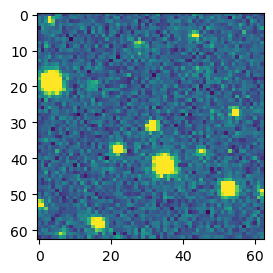

'bogus:'

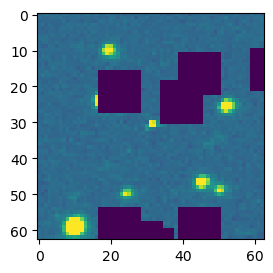

'real:'

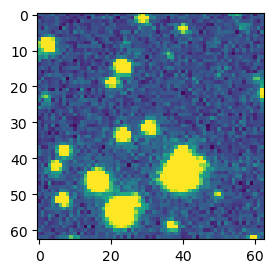

'bogus:'

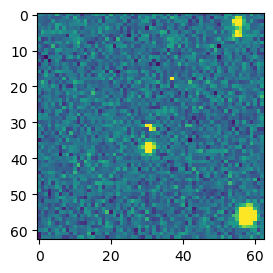

'real:'

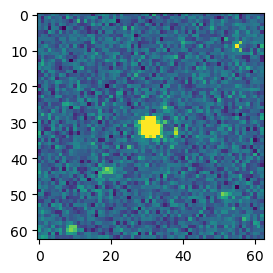

'real:'

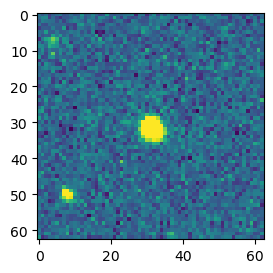

'real:'

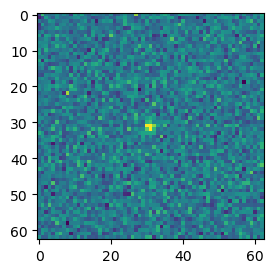

'platypus:'

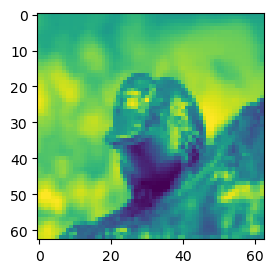

'bogus:'

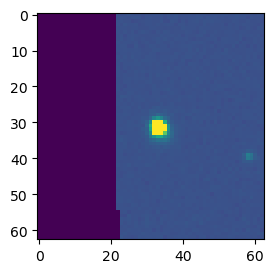

'real:'

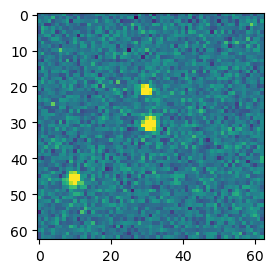

'real:'

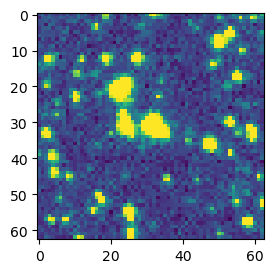

'platypus:'

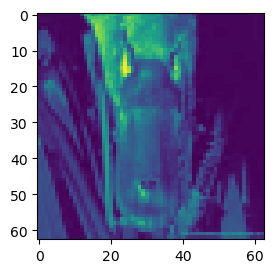

'platypus:'

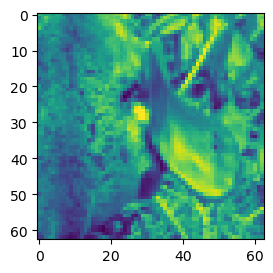

'real:'

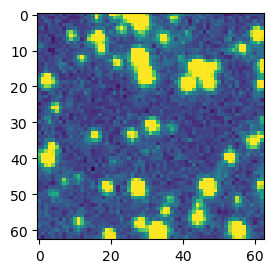

'bogus:'

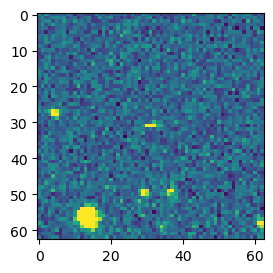

'platypus:'

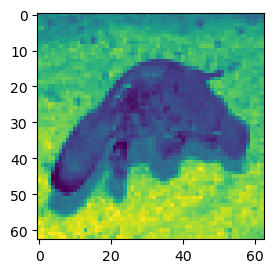

'real:'

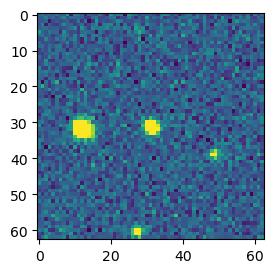

'bogus:'

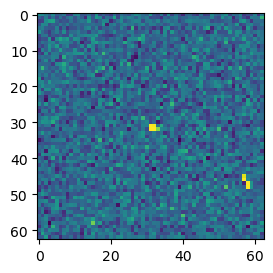

'real:'

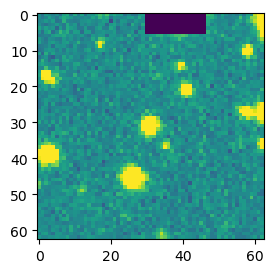

'bogus:'

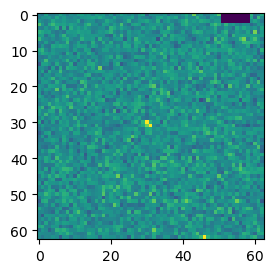

'platypus:'

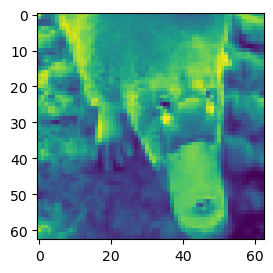

'bogus:'

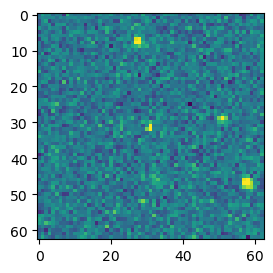

'real:'

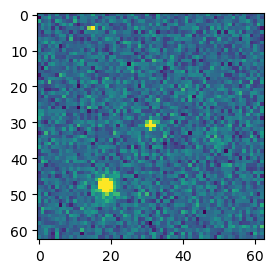

'bogus:'

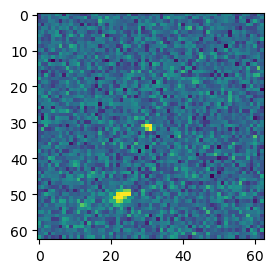

'real:'

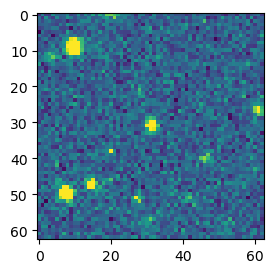

'bogus:'

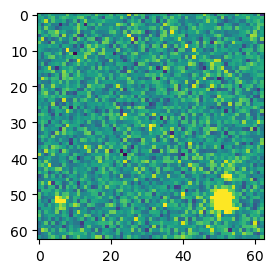

In [22]:
ll = {0: 'bogus', 1: 'real', 2: 'platypus'}

for ii in test_indexes:
    interval = ZScaleInterval()
    limits = interval.get_limits(data[ii, ..., 0])

    fig = plt.figure(figsize=(3, 3), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(data[ii, ..., 0], vmin=limits[0], vmax=limits[1])

    p = np.argmax(model_tl.predict(np.expand_dims(data[ii], axis=0))[0])
    display(f"{ll[p]}:")

    plt.show()
    # break

## Unsolicited wisdom

Even though this may seem like some ridiculous nonsense, you've actually implemented a real-life
transfer learning pipeline:
you took an off-the-shelf production DL model, then using a part of it as a pre-trained feature extractor,
adapted its architecture to a different problem, and trained on data the original model never saw, achieving
very good results.


# Problem 2: Deep learning for SCoPe

### Import Data

We first load the data from the dataset file and save it in ```df_raw_data```. Then, we extract the features/labels used in the paper and save them in ```df_feats``` and ```df_labels``` respectively.

In [73]:
# Import Packages
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

In [154]:
DATA_PATH = '../../scope/data/dataset.csv'
df_raw_data = pd.read_csv(DATA_PATH)

In [155]:
LABELS_COL = [# 10 Cols for the phenomenological classifiers 
              'variable', 'periodic', 'long timescale', 'irregular', 'eclipsing', 'EA', 'EB', 'EW', 'flaring', 'bogus',
              # new
              'non-variable', 'dipping', 'blend', 'bright star', 'ccd artifact', 'galaxy', 'sinusoidal', 'sawtooth', 
              'elliptical',
    
    
              # 13 Cols for the ontological classifiers
              'pulsator', 'Delta Scu', 'Cepheid', 'RR Lyrae', 'LPV', 'Mira', 'SRV', 'binary star', 'W Uma', 'Beta Lyr',
              'RS CVn', 'AGN', 'YSO',
              # new
              'F', 'O', 'Cepheid type-II', 'detached eclipsing MS-MS', 'compact binary', 'eclipsing WD+dM (NN Ser)',
              'eclipsing sdB+dM (HW Vir)', 'RR Lyrae Blazhko', 'RR Lyrae ab', 'RR Lyrae c', 'RR Lyrae d', 'BL Her', 
              'RV Tau', 'W Virginis',  
    
              # unclear:
              'double period', 'half period', 'multi periodic', 'nice', 'niice', 'wrong period',
             ]

FEATS_COL = [# 38 Cols for the phenomenological classifiers 
             'period', 'significance', 'n', 'median', 'wmean', 'wstd', 'chi2red', 'roms', 'norm_peak_to_peak_amp',
             'norm_excess_var', 'median_abs_dev', 'iqr', 'f60', 'f70', 'f80' , 'f90', 'skew', 'smallkurt', 
             'inv_vonneumannratio', 'welch_i', 'stetson_j', 'stetson_k', 'ad', 'sw', 'f1_power', 'f1_bic','f1_amp', 
             'f1_phi0', 'f1_relamp1', 'f1_relphi1', 'f1_relamp2', 'f1_relphi2', 'f1_relamp3', 'f1_relphi3', 'f1_relamp4', 
             'f1_relphi5', 'n_ztf_alerts', 'mean_ztf_alert_braai',  
             
             # 30 Cols for the ontological classifiers
             'AllWISE__w1mpro', 'AllWISE__w1sigmpro', 'AllWISE__w2mpro', 'AllWISE__w2sigmpro', 'AllWISE__w3mpro',
             'AllWISE__w3sigmpro', 'AllWISE__w4mpro','AllWISE__w4sigmpro', 'AllWISE__ph_qual',
             'Gaia_DR2__phot_g_mean_mag', 'Gaia_DR2__phot_bp_mean_mag', 'Gaia_DR2__phot_rp_mean_mag', 'Gaia_DR2__parallax',
             'Gaia_DR2__parallax_error', 'Gaia_DR2__pmra', 'Gaia_DR2__pmra_error', 'Gaia_DR2__pmdec', 'Gaia_DR2__pmdec_error',
             'Gaia_DR2__astrometric_excess_noise', 'Gaia_DR2__phot_bp_rp_excess_factor',
             'PS1_DR1__gMeanPSFMag', 'PS1_DR1__gMeanPSFMagErr', 'PS1_DR1__rMeanPSFMag', 'PS1_DR1__rMeanPSFMagErr', 
             'PS1_DR1__iMeanPSFMag', 'PS1_DR1__iMeanPSFMagErr', 'PS1_DR1__zMeanPSFMag', 'PS1_DR1__zMeanPSFMagErr', 
             'PS1_DR1__yMeanPSFMag', 'PS1_DR1__yMeanPSFMagErr', 'PS1_DR1__qualityFlag']


df_feats = df_raw_data[FEATS_COL]
df_labels = df_raw_data[LABELS_COL]

In [156]:
# Encode the labels
df_labels = df_labels.apply(LabelEncoder().fit_transform)

# Special case: Convert string to float
df_feats['AllWISE__ph_qual'] = LabelEncoder().fit_transform(df_feats['AllWISE__ph_qual'])

# Normalization
df_feats_values = df_feats.values
df_feats_values_scaled = StandardScaler().fit_transform(df_feats_values)
df_feats_scaled = pd.DataFrame(df_feats_values_scaled, columns=df_feats.columns)
df_feats_scaled

/var/folders/sy/hzdk6bx960n0xc_cxxz5n31r0000gq/T/ipykernel_72409/3673800119.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feats['AllWISE__ph_qual'] = LabelEncoder().fit_transform(df_feats['AllWISE__ph_qual'])


,period,significance,n,median,wmean,wstd,chi2red,roms,norm_peak_to_peak_amp,norm_excess_var,...,PS1_DR1__gMeanPSFMagErr,PS1_DR1__rMeanPSFMag,PS1_DR1__rMeanPSFMagErr,PS1_DR1__iMeanPSFMag,PS1_DR1__iMeanPSFMagErr,PS1_DR1__zMeanPSFMag,PS1_DR1__zMeanPSFMagErr,PS1_DR1__yMeanPSFMag,PS1_DR1__yMeanPSFMagErr,PS1_DR1__qualityFlag
0,1.795541,-0.411116,1.056842,-0.080996,-0.070772,-0.729371,-0.204919,-0.618402,-0.556206,-0.090013,...,-0.505132,-0.171156,-0.711477,-0.108664,-0.679382,-0.035408,-0.589965,0.087552,-0.428986,0.202861
1,-0.169144,-0.404608,-0.609176,1.717669,1.745705,0.605940,-0.203427,-0.567115,-0.058580,-0.067296,...,-0.771984,1.529579,2.328723,1.432994,0.796992,1.331472,0.413797,1.111349,-0.121882,-0.577069
2,-0.168778,-0.339781,-0.709640,1.355583,1.383824,0.625651,-0.194344,-0.467194,0.354400,-0.022121,...,6.291251,1.346526,0.143841,1.067136,0.790237,0.829973,0.215383,0.617988,-0.170997,0.202861
3,-0.167949,-0.153682,-0.575688,0.376213,0.371072,0.035347,-0.164693,-0.161056,-0.089659,-0.064653,...,0.079213,0.424836,0.335221,0.589397,-0.315000,0.697595,-0.091769,0.706519,0.258703,-0.577069
4,-0.167962,-0.326416,-0.475225,-0.960383,-0.960730,-0.642459,-0.187080,-0.368344,-0.677252,-0.087730,...,-0.414266,-0.674166,-0.685891,-0.570005,-0.178704,-0.493979,-0.272985,-0.272220,-0.641119,0.202861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.168765,0.561914,0.043836,0.225089,0.251542,0.162925,-0.099879,0.132890,0.162960,-0.048426,...,0.408199,0.312270,-0.127323,0.312456,-0.503739,0.356175,0.212744,0.361095,-0.558559,0.202861
69996,-0.168783,0.347649,-0.575688,-0.698025,-0.672249,0.112984,0.255438,1.149209,-0.028490,-0.048638,...,0.943568,-0.446250,0.416117,-0.382705,0.143071,-0.370791,-0.387639,-0.145787,0.548454,0.202861
69997,-0.169044,-0.325871,-0.684524,0.065781,0.067812,-0.388981,-0.175824,-0.255117,-0.473654,-0.082420,...,-0.115449,0.177809,0.047016,0.365860,-0.339711,0.478386,-0.262794,0.483536,-0.033011,0.202861
69998,-0.169061,-0.310516,-0.684524,0.418150,0.422739,-0.051247,-0.177880,-0.267395,-0.220118,-0.070384,...,0.203350,0.476170,0.174543,0.662414,0.414358,0.802405,-0.355381,0.747981,0.037455,-0.577069


In [228]:
# Train / test split
rs=8581
X_train, X_test, y_train, y_test = train_test_split(df_feats_scaled.values, df_labels.values, test_size=0.5, 
                                                    random_state=rs)

In [229]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

The DNN model consists of three parts:
1. Autoencoder, which has a encoder that compresses the information and a decoder that reconstructs the information. 
2. Classifiers: for each label, we have one independent classifier.
3. CNN, which is commonly-used in image processing area.

In [230]:
# this is a simple classifier for single label
class classifier(nn.Module):
    def __init__(self, label_name_):
        super().__init__()
        self.fc1 = nn.Linear(in_features=16, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=16)
        self.outputfc = nn.Linear(in_features=16, out_features=df_labels[label_name_].nunique())
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.outputfc(x)
        return x

In [231]:
class MLP_0(nn.Module):
    def __init__(self, model_list:list):
        super().__init__()
        # ==============AUTOENCODER================
        # encoder
        self.enc1 = nn.Linear(in_features=69, out_features=64)
        self.enc2 = nn.Linear(in_features=64, out_features=32)
        self.enc_out = nn.Linear(in_features=32, out_features=16) # output encoded tensor
        # decoder
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec_out = nn.Linear(in_features=64, out_features=69) # output decoded data
        # ==========================================
        
        self.classifiermodels=[]
        for i in range(len(model_list)):
            self.classifiermodels.append(model_list[i])
        
        
    def forward(self, x):
        
        enc_data = F.relu(self.enc1(x))
        enc_data = F.relu(self.enc2(enc_data))
        enc_data = self.enc_out(enc_data)
        
        dec_data = F.relu(self.dec1(enc_data))
        dec_data = F.relu(self.dec2(dec_data))
        dec_data = self.dec_out(dec_data)
        
        outlist=[]
        for i in range(len(model_list)):
            outlist.append(self.classifiermodels[i].forward(enc_data))
        
        return dec_data, outlist

In [233]:
LABELS_COL_TO_TRAIN = ['variable']
model_list=[classifier(label_name_) for label_name_ in LABELS_COL_TO_TRAIN]
model = MLP_0(model_list)

In [234]:
# number of parameters in model, from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/25
sum(p.numel() for p in model.parameters())+sum([sum(p.numel() for p in model_.parameters()) for model_ in model_list])+sum(p.numel() for p in net.parameters())

86591

In [235]:
# Hyper-parameters
epochs = 10
learning_rate = 1e-3

# DataLoader 
train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())  # Pytorch uses FP32
train_ldr = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=False)
test_data = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())  # Pytorch uses FP32

In [236]:
classifierparaml=[]
for model_element in model_list:
    classifierparaml+=(model_element.parameters())

In [237]:
criterion_MSE = nn.MSELoss()
criterion_CE = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.parameters())
                             +list(classifierparaml), lr=learning_rate)

In [241]:
# Training
loss_list = []
for model_s in model.classifiermodels:
    model_s.train()

for i in range(epochs):
    for (batch_idx, batch) in enumerate(train_ldr):
        X_train_batch = batch[0]
        y_train_batch = batch[1]

        X_reco, outlist_ = model.forward(X_train_batch)
        
        # label_loss_=label_loss(y_pred_l1.int(), y_pred_l2.int(), y_pred_l3.int()), reserved for future use

        loss_1 = criterion_MSE(X_reco, X_train_batch)
        loss_2 = 0.
        for j in range(len(LABELS_COL_TO_TRAIN)):
            loss_2 += criterion_CE(outlist_[j], y_train_batch[:,j])
            #print(loss)
        loss = loss_1 + loss_2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 50 == 0:
            #print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss1: {:0.4f} Loss2: {:0.4f} Loss: {:0.4f}".format(i, batch_idx, loss_1, loss_2 ,loss))


Epoch: 0, batch: 0 Loss1: 0.1553 Loss2: 4.0109 Loss: 4.1662
Epoch: 0, batch: 50 Loss1: 0.2906 Loss2: 0.6194 Loss: 0.9100
Epoch: 0, batch: 100 Loss1: 0.2196 Loss2: 0.2593 Loss: 0.4789
Epoch: 1, batch: 0 Loss1: 0.1705 Loss2: 0.2700 Loss: 0.4406
Epoch: 1, batch: 50 Loss1: 0.2189 Loss2: 0.1757 Loss: 0.3947
Epoch: 1, batch: 100 Loss1: 0.1929 Loss2: 0.2133 Loss: 0.4061
Epoch: 2, batch: 0 Loss1: 0.1573 Loss2: 0.2212 Loss: 0.3785
Epoch: 2, batch: 50 Loss1: 0.2090 Loss2: 0.1607 Loss: 0.3697
Epoch: 2, batch: 100 Loss1: 0.1864 Loss2: 0.1976 Loss: 0.3840
Epoch: 3, batch: 0 Loss1: 0.1517 Loss2: 0.2001 Loss: 0.3517
Epoch: 3, batch: 50 Loss1: 0.2009 Loss2: 0.1538 Loss: 0.3546
Epoch: 3, batch: 100 Loss1: 0.1790 Loss2: 0.1876 Loss: 0.3666
Epoch: 4, batch: 0 Loss1: 0.1476 Loss2: 0.1925 Loss: 0.3401
Epoch: 4, batch: 50 Loss1: 0.1933 Loss2: 0.1489 Loss: 0.3421
Epoch: 4, batch: 100 Loss1: 0.1755 Loss2: 0.1802 Loss: 0.3557
Epoch: 5, batch: 0 Loss1: 0.1438 Loss2: 0.1869 Loss: 0.3307
Epoch: 5, batch: 50 Loss1

In [242]:
# Prediction
preds = []
with torch.no_grad():
    X_reco_final, outlist_final = model.forward(torch.tensor(X_test).float())
print("The prediction result: \n", X_reco_final)

The prediction result: 
 tensor([[-0.3646,  1.2296, -0.4969,  ...,  0.1738,  0.2431, -0.0384],
        [-0.0640, -0.2750,  0.0302,  ...,  1.0403,  0.2670, -0.2605],
        [-0.0247, -0.4265,  0.4165,  ...,  0.5230,  0.3686, -0.3568],
        ...,
        [-0.3431, -0.0979, -0.2816,  ...,  0.4968,  0.1121, -0.0314],
        [-0.3105,  0.2567, -0.7502,  ...,  0.4127, -0.0817, -0.1184],
        [-0.3807,  0.0970, -0.7307,  ...,  0.3574,  0.1361,  0.2661]])


variable 0.9589714285714286
The mean accuracy:  0.9589714285714286


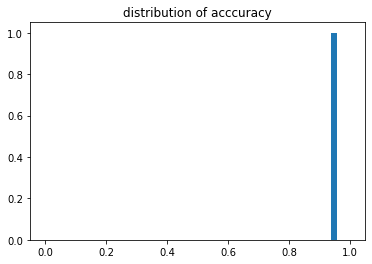

In [243]:
# Function for evaluation:
# Calculate the accuracy for each class
from sklearn.metrics import accuracy_score

def get_accuracy(y_true, y_pred):
    acc_list=[]

    for i in range(y_true.shape[1]):
        print(y_true[:, i], y_pred[:, i])
        acc_list.append(accuracy_score(y_true[:, i], y_pred[:, i]))

    return np.array(acc_list)

scorelist=[(accuracy_score(F.softmax(outlist_final[iii], dim=1).argmax(dim=1).cpu(), y_test[:, iii])) for iii in range(len(LABELS_COL_TO_TRAIN))]
for iii in range(len(LABELS_COL_TO_TRAIN)):
    print(LABELS_COL_TO_TRAIN[iii], scorelist[iii])

# Evaluation
print("The mean accuracy: ", np.mean(scorelist))

import matplotlib.pyplot as plt
plt.hist(scorelist, bins=np.linspace(0., 1, 50))
plt.title("distribution of acccuracy")
plt.show()

## Challenge: Hierarchial model: modify the loss function

Beside the reconstruction and classification loss functions, we may add a "dependence loss", which is hierarchy-related and is regarded as a punishment when predictions are not consistent with the category structure. 

In [ ]:
def label_loss(y_pred1, y_pred2, y_pred3):
    loss_ = torch.bitwise_and(y_pred1[:,L1_label.index("eclipsing")]==0, y_pred2[:,L2_label.index("EA")]!=0).sum()+\
    torch.bitwise_and(y_pred1[:,L1_label.index("eclipsing")]==0, y_pred2[:,L2_label.index("EB")]!=0).sum()+\
    torch.bitwise_and(y_pred1[:,L1_label.index("eclipsing")]==0, y_pred2[:,L2_label.index("EW")]!=0).sum()+\
    torch.bitwise_and(y_pred1[:,L1_label.index("pulsator")]==0, y_pred2[:,L2_label.index("Delta Scu")]!=0).sum()+\
    torch.bitwise_and(y_pred1[:,L1_label.index("pulsator")]==0, y_pred2[:,L2_label.index("Cepheid")]!=0).sum()+\
    torch.bitwise_and(y_pred1[:,L1_label.index("pulsator")]==0, y_pred2[:,L2_label.index("RR Lyrae")]!=0).sum()+\
    torch.bitwise_and(y_pred1[:,L1_label.index("pulsator")]==0, y_pred2[:,L2_label.index("LPV")]!=0).sum()+\
    torch.bitwise_and(y_pred2[:,L2_label.index("LPV")]==0, y_pred3[:,L3_label.index("Mira")]!=0).sum()+\
    torch.bitwise_and(y_pred2[:,L2_label.index("LPV")]==0, y_pred3[:,L3_label.index("SRV")]!=0).sum()+\
    torch.bitwise_and(y_pred1[:,L1_label.index("binary star")]==0, y_pred2[:,L2_label.index("W Uma")]!=0).sum()+\
    torch.bitwise_and(y_pred1[:,L1_label.index("binary star")]==0, y_pred2[:,L2_label.index("Beta Lyr")]!=0).sum()+\
    torch.bitwise_and(y_pred1[:,L1_label.index("binary star")]==0, y_pred2[:,L2_label.index("RS CVn")]!=0).sum()
    # ...
    return loss_

The total loss function then becomes $$L_{reco}+\alpha\times L_{class}+ \beta \times L_{dep}$$
where $\alpha$ and $\beta$ are weights for different loss functions. 